# Power Confounds

### Issue

Many measures of interest are implicitly dependent on the signal strength, or, effectively, the relative power, of the oscillations under study. This can also be though of as the signal-to-noise ratio of the data under study. If the power of the oscillation is low, then measures may be 'noisy', exhibiting high variability due a difficulty in resolving measurements.

### Solution

For analyses of interest, consider the required signal-to-noise ratio to get good measurements. Several strategies may be useful to optimize signal strength, including thing like using individualized frequency ranges to more specifically detect oscillations, and applying burst detection to any analyze data with rhythms present. In some cases, an amplitude threshold may be useful to select data of a high-enough magnitude for subsequent analyses. 

### Related Work

ToDo: add any other work explicitly discussing / demonstrating this issue. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof.utils import trim_spectrum
from fooof.plts.spectra import plot_spectrum_shading

from neurodsp.sim import sim_combined
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time
from neurodsp.utils import create_times, remove_nans, set_random_seed
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure

## Settings

In [2]:
import seaborn as sns
sns.set_context('poster')

In [3]:
# Set random seed
set_random_seed(808)

In [4]:
# Set functions to use for averaging and variance
avg_func = np.nanmedian
var_func = np.nanvar

In [5]:
# Define general simulation settings
n_seconds = 25
fs = 1000
times = create_times(n_seconds, fs)

In [6]:
# Define parameters for the simulations
cf = 10
exp = -2.0
ap_filt = (3, 100)

In [7]:
# Collect parameters and set up simulations
components = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
              'sim_oscillation' : {'freq' : cf}}

# Define relative power of the signal components
comp_vars1 = [1, 1.0]
comp_vars2 = [1, 0.1]

In [8]:
# Define frequency ranges of interest
alpha_range = (8, 12)
psd_range = (4, 35)

In [9]:
plt_kwargs = {'xlim' : [0.5, 4.5], 'xlabel' : '', 'ylabel': ''}

In [10]:
alpha_color = '#1882d9'

## Simulate Time Series

For this, we will simulate signals with oscillations of different relative powers. 

Note that the simulated data vary on relative power, but that the oscillations within each signal are themselves static and consistent. 

This means that any measured variability within the simulations necessarily stems from measurement issues.

In [11]:
# Simulate time series
sig1 = sim_combined(n_seconds, fs, components, comp_vars1)
sig2 = sim_combined(n_seconds, fs, components, comp_vars2)

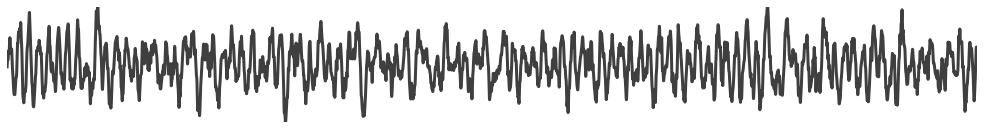

In [12]:
# Plot the time series of the first signal - high power
plot_time_series(times, sig1, alpha=0.75, xlim=[5, 15], ylim=[-3, 3])
plt.axis('off')
plt.savefig('figures/07-ts-highpow.pdf', bbox_inches='tight')

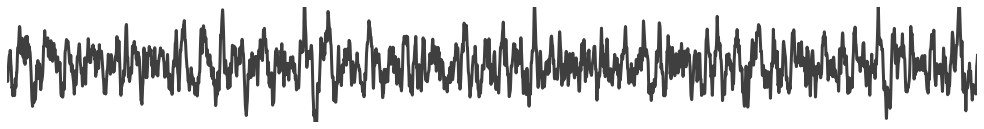

In [13]:
# Plot the time series of the first signal - low power
plot_time_series(times, sig2, alpha=0.75, xlim=[5, 15], ylim=[-3, 3])
plt.axis('off')
plt.savefig('figures/07-ts-lowpow.pdf', bbox_inches='tight')

## Compute Power Spectra

Next we can compute and compare the power spectra of each respective signal. 

This will allow us to visualize and check the relative power within each signal. 

In [14]:
# Compute the power spectra of each of the example signals
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig1, fs, nperseg=fs), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig2, fs, nperseg=fs), psd_range)

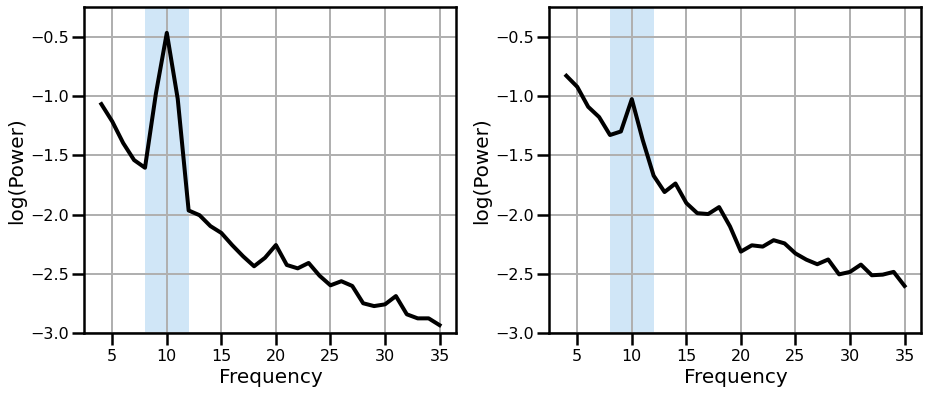

In [15]:
_, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot the power spectra of the two signal
plot_spectrum_shading(freqs1, powers1, alpha_range, log_powers=True,
                     color='black', lw=4, shade_colors=alpha_color, ax=axes[0])
axes[0].set_ylim(-3, -0.25)
plot_spectrum_shading(freqs2, powers2, alpha_range, log_powers=True,
                     color='black', lw=4, shade_colors=alpha_color, ax=axes[1])
axes[1].set_ylim(-3, -0.25)
plt.subplots_adjust(wspace=0.25)

## Compute Instantaneous Measures

Next, let's compute some instantaneous measures of interest on our signals. 

For these examples, we have added an alpha oscillations, so we will examine instantaneous measures of the alpha range. 

In [16]:
# Filter each signal, to the alpha range
sig_filt1 = filter_signal(sig1, fs, 'bandpass', alpha_range)

sig_filt2 = filter_signal(sig2, fs, 'bandpass', alpha_range)

In [17]:
# Compute instantaneous measures, for each signal
pha1 = phase_by_time(sig_filt1, fs)
amp1 = amp_by_time(sig_filt1, fs)
fre1 = freq_by_time(sig_filt1, fs)

pha2 = phase_by_time(sig_filt2, fs)
amp2 = amp_by_time(sig_filt2, fs)
fre2 = freq_by_time(sig_filt2, fs)

## Plot Instantaneous Measures

We can now plot our measures of interest, separately for the high and low power signals, and compare them. 

Recall that there is no temporal variability in the simulated oscillations. 

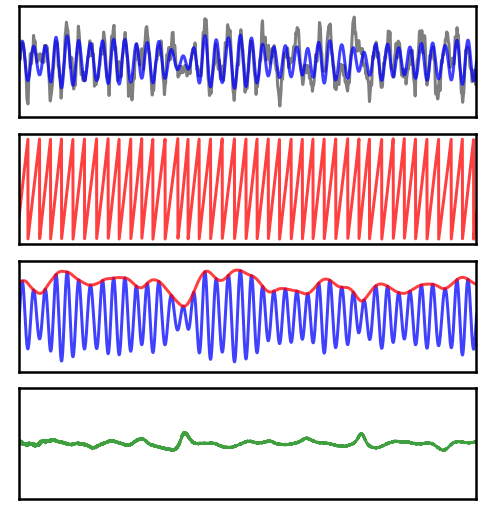

In [18]:
# Plot instantaneous measures for the firt signal (high power)
_, axes = plt.subplots(4, 1, figsize=(8, 8))
plot_time_series(times, [sig1, sig_filt1], ax=axes[0], ylim=[-3, 3],
                 alpha=[0.5, 0.75], colors=['k', 'b'], **plt_kwargs)
plot_instantaneous_measure(times, pha1, 'phase', ax=axes[1],
                           alpha=[0.75], colors='r', **plt_kwargs)
plot_instantaneous_measure(times, [sig_filt1, amp1], 'amplitude', ax=axes[2],
                           alpha=[0.75, 0.75], colors=['b', 'r'], ylim=[-1.75, 1.75], **plt_kwargs)
plot_instantaneous_measure(times, fre1, 'frequency',  ax=axes[3],
                           alpha=[0.75], colors='g', ylim=[0, 20], **plt_kwargs)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.15)
plt.savefig('figures/07-measures-highpow.pdf', bbox_inches='tight')

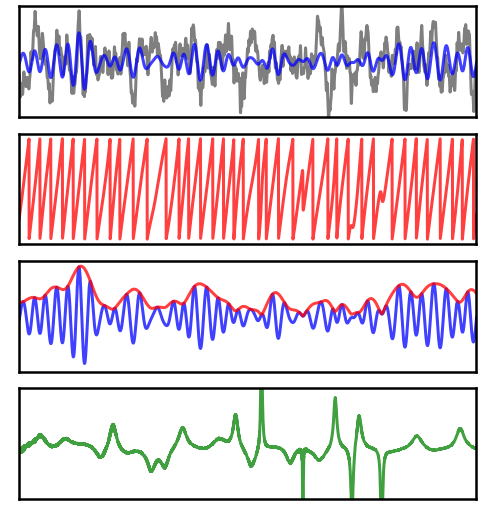

In [19]:
# Plot instantaneous measures for the second signal (low power)
_, axes = plt.subplots(4, 1, figsize=(8, 8))
plot_time_series(times, [sig2, sig_filt2], ax=axes[0], ylim=[-3, 3],
                 colors=['k', 'b'], alpha=[0.5, 0.75], **plt_kwargs)
plot_instantaneous_measure(times, pha2, 'phase', ax=axes[1],
                           alpha=0.75, colors=['r'], **plt_kwargs)
plot_instantaneous_measure(times, [sig_filt2, amp2], 'amplitude', ax=axes[2],
                           ylim=[-1.75, 1.75], alpha=[0.75, 0.75], colors=['b', 'r'], **plt_kwargs)
plot_instantaneous_measure(times, fre2, 'frequency', ax=axes[3],
                           alpha=0.75, colors='g', ylim=[0, 20], **plt_kwargs)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.15)
plt.savefig('figures/07-measures-lowpow.pdf', bbox_inches='tight')

As we can see in the above plots and comparisons, there is much great measured variability in the low power signal. 

This variability does not accurately reflect the underlying signal, but rather is a limitation of the low power. 

## Compare Measures

In the above, we visually compared our measures. 

Next lets more quantitatively compare them, by computing descriptive statistics on the computed measures. 

In [20]:
# Set a buffer to ignore on the edges of the signal, for these comparisons
#   This is just a way to exclude any potential edge artifacts, from the filtering
buff = 1*fs

In [21]:
# Compute descriptive statistics of the first signal (high power)
print('Pha - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(pha1[buff:-buff]), var_func(pha1[buff:-buff])))
print('Amp - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(amp1[buff:-buff]), var_func(amp1[buff:-buff])))
print('Fre - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(fre1[buff:-buff]), var_func(fre1[buff:-buff])))

Pha - mean: -0.0034, var: 3.2903
Amp - mean: +1.0137, var: 0.0747
Fre - mean: +9.9922, var: 0.2983


In [22]:
# Compute descriptive statistics of the first signal (low power)
print('Pha - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(pha2[buff:-buff]), var_func(pha2[buff:-buff])))
print('Amp - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(amp2[buff:-buff]), var_func(amp2[buff:-buff])))
print('Fre - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(fre2[buff:-buff]), var_func(fre2[buff:-buff])))

Pha - mean: +0.0097, var: 3.2859
Amp - mean: +0.6186, var: 0.0860
Fre - mean: +9.6614, var: 8.8604


In the above measures, we see increased variability of the measures, in particular for frequency, and also for amplitude.

Note that the above comparison does not really make sense for phase, a circular variable. 

Therefore, we can compare that one a little differently. For a consistent oscillation, the unwrapped phase should show consistent variation, which can be calculated as the differences between measured (unwrapped) phase values. 

For a better measure of phase, let's compare the unwrapped phases. 

In [23]:
# Compute unwrapped phase diffs for the first signal (high power)
pha1_uw = np.unwrap(remove_nans(pha1[buff:-buff])[0])
pha1_diffs = np.diff(pha1_uw)

# Compute unwrapped phase diffs for the first signal (low power)
pha2_uw = np.unwrap(remove_nans(pha2[buff:-buff])[0])
pha2_diffs = np.diff(pha2_uw)

In [24]:
# Compute descriptive statistics of the first signal (low power)
print('Pha (sig1) - mean: {:+1.4f}, var: {:1.5f}'.format(\
    avg_func(pha1_diffs[buff:-buff]), var_func(pha1_diffs[buff:-buff])))
print('Pha (sig2) - mean: {:+1.4f}, var: {:1.5f}'.format(\
    avg_func(pha2_diffs[buff:-buff]), var_func(pha2_diffs[buff:-buff])))

Pha (sig1) - mean: +0.0628, var: 0.00001
Pha (sig2) - mean: +0.0610, var: 0.00036


An additional phase measure we can check is phase monotonicity. 

The unwrapped phase of ongoing oscillations should be monotonically increasing. 

However, in some cases, we can see 'phase slips', or a negative deflection of the measured (unwrapped) phase. 

The phase monotonicity for the measured signals is another measure of variable, whereby (for this case) higher values are more accurate. 

In [25]:
# Comptute and compare the measured phase monotonicity of the signals
print('Phase monotonicity (sig 1):  {:1.4f}'.format(\
    sum(pha1_diffs >= 0) / len(pha1_diffs)))
print('Phase monotonicity (sig 2):  {:1.4f}'.format(\
    sum(pha2_diffs >= 0) / len(pha2_diffs)))

Phase monotonicity (sig 1):  1.0000
Phase monotonicity (sig 2):  0.9958


## Conclusion

Measurements of neural oscillations are often implicitly dependent on the power of the observed oscillation. 

As we've seen here, examining low powered oscillations can often lead to noisy measurements. 

Various approaches can be taken, and may sometimes be needed, to restrict analyses to segments of data which enough power to robustly measure. 